# Computing the pressure

In this notebook, we demonstrate the calculation of the pressure field---both in the fluid as well as on the surface---in a few situations

We will now consider two examples. In these examples, we use the following grid.

In [2]:
using GridPotentialFlow
using Plots
Δx = 0.01
Lx = 4.0
xlim = (-Lx/2,Lx/2)
ylim = (-Lx/2,Lx/2)
g = PhysicalGrid(xlim,ylim,Δx);

┌ Info: Precompiling GridPotentialFlow [1f0d46c9-1630-4f7c-9a63-ed825740f08c]
└ @ Base loading.jl:1317


In [3]:
using UnPack

## Vortex near a cylinder

As an basic example, consider now a point vortex near a circular cylinder.

In [87]:
RadC = Lx/4
Δs0 = 1.4*cellsize(g);
body = PotentialFlowBody(Circle(RadC,Δs0));
Δs = areas(body).data;

We choose an initial position $R_v$ of the vortex at $3/2 R_c$ from the origin.

In [88]:
Rv = 3/2*RadC
Γv = 1.0
v = Vortex(Rv,0.0,Γv);

In [89]:
setΓ(body,-Γv)

-1.0

Analytical solution (vortex at Rv and image vortex at Rc^2/Rv)

In [90]:
x, y = body.points.x, body.points.y
r1 = sqrt.((x.-Rv).^2 .+ y.^2) # distance from vortex to points on circle
r2 = sqrt.((x.-RadC^2/Rv).^2 .+ y.^2) # distance from image vortex to points on circle
θ1 = π.+atan.(y./(x.-Rv)) # angle from vortex to points on circle
θ2 = atan.(y,(x.-RadC^2/Rv)) # angle from image vortex to points on circle
v1x = -v.Γ./(2π*r1).*cos.(θ1.-π/2) # x velocity on circle induced by vortex
v1y = -v.Γ./(2π*r1).*sin.(θ1.-π/2) # y velocity on circle induced by vortex
v2x = v.Γ./(2π*r2).*cos.(θ2.-π/2) # x velocity on circle induced by image vortex
v2y = v.Γ./(2π*r2).*sin.(θ2.-π/2) # y velocity on circle induced by image vortex
V = sqrt.((v1x.+v2x).^2+(v1y.+v2y).^2) # velocity magnitude on circle
γ = -V; # bound vortex sheet strength on circle (velocity on circle is clockwise if positive vortex is to the right of it)

### Find the analytical pressure distribution on the surface

In [91]:
zc = x + im*y;
zv = complex(Rv)

1.5 + 0.0im

In [92]:
Fc(z) = Γv/(2π*im)*log(z - zv) - Γv/(2π*im)*log(z - RadC^2/conj(zv))
wcv(z) = Γv/(2π*im)/(z-zv)
wci(z) = -Γv/(2π*im)/(z-RadC^2/conj(zv))
wc(z) = wcv(z) + wci(z)
wv = wci(zv)
dFdzv(z) = -Γv/(2π*im)/(z-zv)
dFdzvstar(z) = -Γv/(2π*im)/(z-RadC^2/conj(zv))*(RadC^2/conj(zv)^2)
Ḟ(z) = dFdzv(z)*conj(wv) + dFdzvstar(z)*wv
press(z) = -real(Ḟ(z)) - 0.5*abs2(wc(z));

Let's check that the analytical force computed from pressure agrees with that computed by rate of change of impulse:

In [93]:
dz = 0.5*circshift(zc,-1) - 0.5*circshift(zc,1)
force_pressure = sum(im*press.(zc).*dz)

0.1060998170143219 + 1.441988889405721e-17im

In [94]:
force_imp = im*Γv*(conj(wv)+RadC^2/conj(zv)^2*wv)

0.10610329539459691 + 0.0im

## Set up a vortex model 

In [97]:
model = VortexModel(g,vortices=[v],bodies=[body]);
X = VectorData(collect(model.bodies));
Xv = getvortexpositions(model);

Δt = 0.01
fn = ScalarData(X);
fnm1 = ScalarData(X);
fnp1 = ScalarData(X);
Ẋn = similar(Xv)
Ẋnp1 = similar(Xv);

#### Move the vortices by one step

In [101]:
Ẋ = vortexvelocities!(model)
soln = solve(model);
Ẋn .= Ẋ
fn .= soln.f
γn = fn./Δs
Xv = getvortexpositions(model)
Xv = Xv + Ẋn*Δt
setvortexpositions!(model,Xv)
Xv = getvortexpositions(model)
Ẋ = vortexvelocities!(model);
solnp1 = solve(model);
Ẋnp1 .= Ẋ
fnp1 .= solnp1.f;
γnp1 = fnp1./Δs;

We can then easily retrieve the streamfunction and the bound vortex sheet strength from the fields of the solution variable.

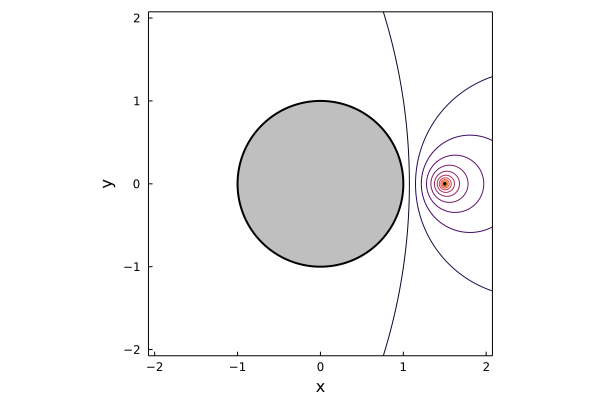

In [102]:
plot(soln.ψ,g)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2)
scatter!([v.x],[v.y],color=:black,markersize=2,xlabel="x",ylabel="y")

For this example, we can easily calculate the analytical bound vortex sheet strength $\gamma$ and compare it with our numerical solution $f$.

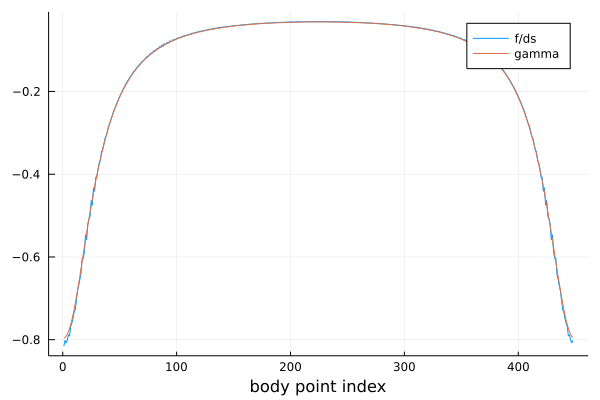

In [103]:
plot(γn,label="f/ds",xlabel="body point index")
plot!(γ,label="gamma")

### Plot the surface velocities

In [104]:
v̄ = Edges(Primal,soln.ψ)
v̄s = VectorData(X)
n_cross_v = ScalarData(X)
velocity!(v̄,soln.ψ,model.ilsys)
surface_velocity!(v̄s,v̄,model.ilsys)

@unpack base_cache = model.ilsys
@unpack g, nrm = base_cache

cross!(n_cross_v,nrm,v̄s);

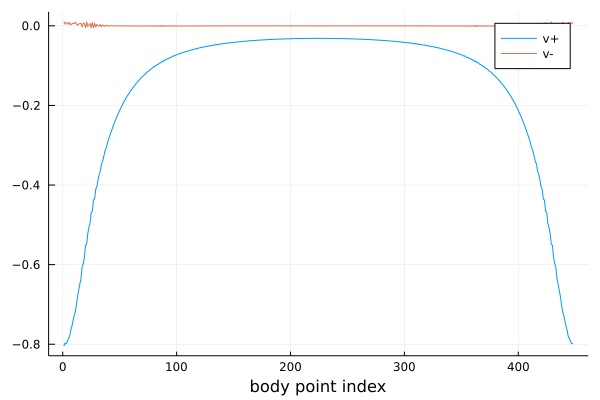

In [105]:
plot(n_cross_v .+ 0.5*γn,label="v+",xlabel="body point index")
plot!(n_cross_v .- 0.5*γn,label="v-")

### Calculate the jump in pressure across the interface

In [106]:
dp = ScalarData(X)
pressurejump!(dp,γn,γnp1,v̄s,Δt,model.ilsys);

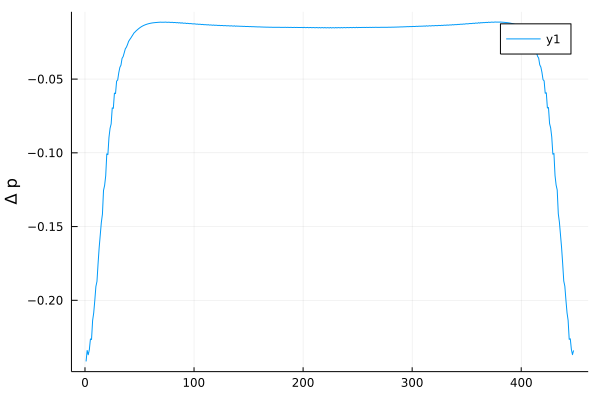

In [107]:
plot(dp,ylabel="\\Delta p")

### Calculate the pressure field everywhere

In [108]:
p̄ = Nodes(Primal,soln.ψ)
pressure!(p̄,v̄,dp,model.ilsys);

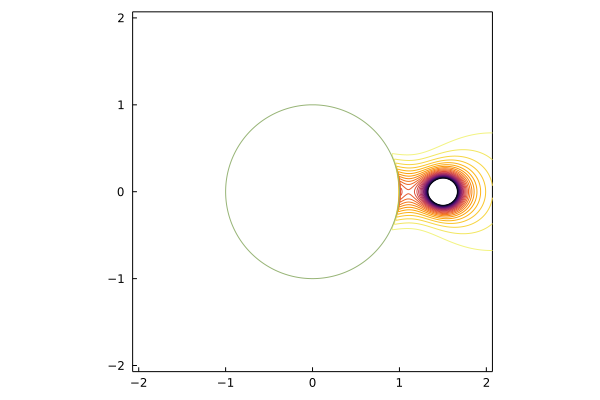

In [113]:
plot(p̄,g,clim=(-0.5,0),levels=range(-0.5,0,length=31))
plot!(body,fillalpha=0)

Note that, because the pressure jump is accounted for in this calculation, the non-zero pressure is confined to the region outside the body.

### Now calculate the pressures on the interface, outside and inside

In [114]:
p⁺, p⁻ = sided_pressures(p̄,dp,model.ilsys);

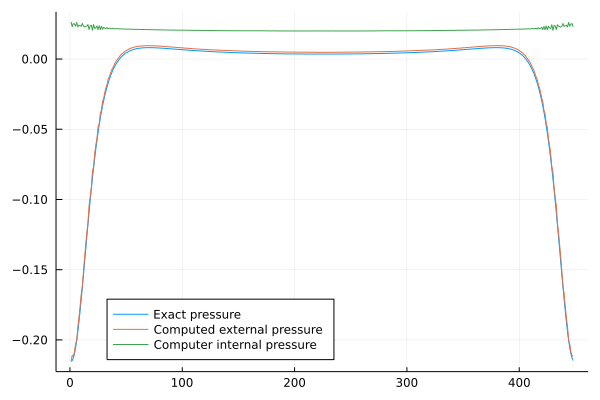

In [116]:
plot(press.(zc),label="Exact pressure",legend=:bottom)
plot!(p⁺,label="Computed external pressure")
plot!(p⁻,label="Computer internal pressure")

## Moving ellipse

In this example we will create a model with a body accelerating from rest, and compute the pressure that develops in the first instant. This pressure is the reaction to acceleration, and is associated with the added mass.

In [117]:
a, b = RadC/4, RadC
Ub, Vb = 0.0, 1.0
body = PotentialFlowBody(Ellipse(a,b,1.4*cellsize(g)), U=(Ub,Vb))
Δs = areas(body).data;
model = VortexModel(g,bodies=[body]);
sol = solve(model);

### Analytical solution

In [118]:
c1, cm1 = (a+b)/2, (a-b)/2
Wr = Ub -im*Vb;

Fs(θ) = -conj(Wr*c1)*exp(-im*θ) + Wr*cm1*exp(-im*θ)
z(θ) = c1*exp(im*θ) + cm1*exp(-im*θ)
zp(θ) = c1 - cm1.*exp(-2*im*θ)
γs(θ) = real(-im*2*Wr*c1*exp(im*θ)/abs(zp(θ)))

γs (generic function with 1 method)

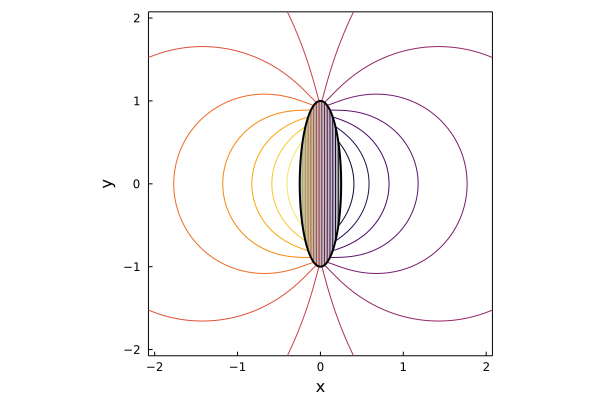

In [119]:
plot(sol.ψ,g)
plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black,linewidth=2,xlabel="x",ylabel="y")

Again, we can compare the discrete bound vortex sheet strength with the analytical vortex sheet strength.

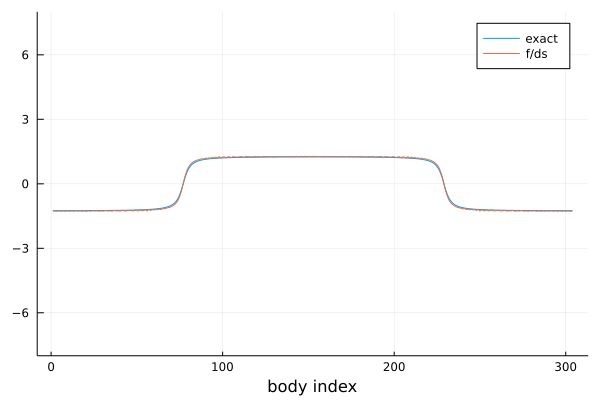

In [120]:
θ = atan.(body.points.y/b,body.points.x/a);
plot(γs.(θ),ylim=(-8,8),label="exact",xlabel="body index")
plot!(sol.f./Δs,label="f/ds")

To calculate the pressure, we assume that the body has accelerated from rest to velocity `U` in time $\Delta t$. In vanishing time increment, the velocity itself is zero, so only the time
derivative terms contribute to pressure.

In [121]:
v̄ = Edges(Primal,sol.ψ)
v̄s = VectorData(length(body))

γn = ScalarData(length(body))
γnp1 = sol.f./Δs
Δt = 1.0

dp = ScalarData(length(body))
pressurejump!(dp,γn,γnp1,v̄s,Δt,model.ilsys);

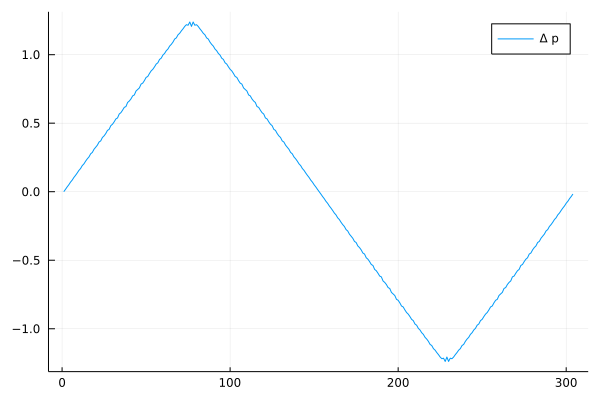

In [122]:
plot(dp,label="\\Delta p")

In [123]:
p̄ = Nodes(Primal,sol.ψ)
pressure!(p̄,v̄,dp,model.ilsys);

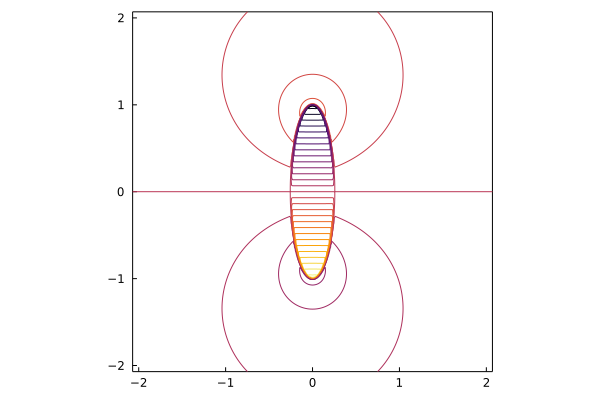

In [124]:
plot(p̄,g,clim=(-1,1),levels=range(-1,1,length=31))

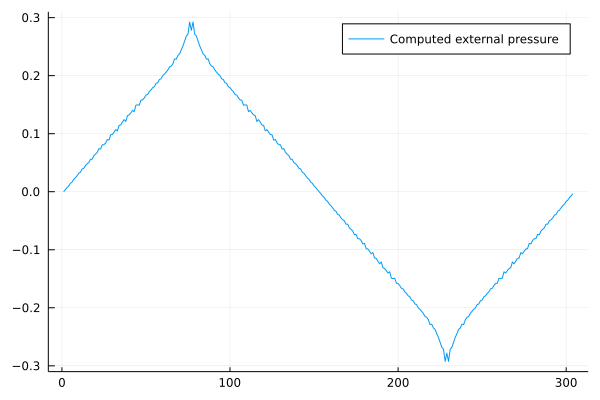

In [125]:
p⁺, p⁻ = sided_pressures(p̄,dp,model.ilsys);
plot(p⁺,label="Computed external pressure")

The integral of the external pressure in the $x$ and $y$ directions represents the inertial reaction force, proportional to the added mass: 

In [126]:
dsn = areas(body)∘normals(body);
[sum(dsn.u ∘ p⁺);
sum(dsn.v ∘ p⁺)]

2-element Vector{Float64}:
 -2.210210654565183e-10
  0.19991869185004782

The actual force due to added mass is

In [127]:
M = [π*b^2 0; 0 π*a^2]
M*[Ub;Vb]

2-element Vector{Float64}:
 0.0
 0.19634954084936207

Note that the internal pressure is a constant multiple of the $y$ coordinate. This is consistent with the fact that the internal scalar potential field is

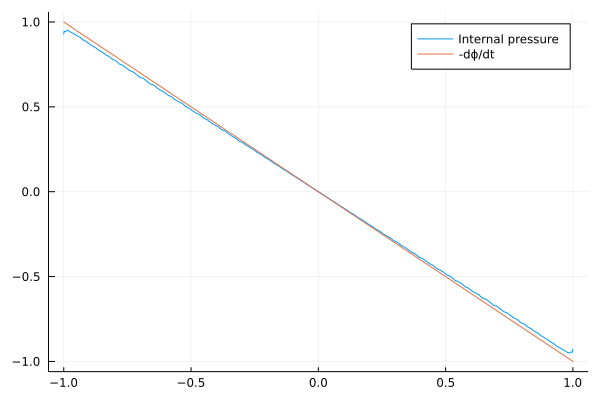

In [128]:
dϕdt = Ub*body.points.x+Vb*body.points.y
plot(body.points.y,p⁻,label="Internal pressure")
plot!(body.points.y,-dϕdt,label="-dϕ/dt")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*